# Slab geometry
In this notebook, we calculate the bands of an infinite slab of SnTe for three different surfaces: [001], [110], [111], as the are supposed to be perpendicular to the mirror symmetry that protects these states. Eventually we want to evaluate for a thickness of 50 nm. These are the typical sizes that we grow in the lab. So for the [001] direction, this comes down to about 80 atoms, assuming a lattice constant of $a = 6,3268 \overset{\circ}{A}$.

In [1]:
import qsymm
import kwant
import numpy as np
import sympy
from IPython.display import display
from IPython.display import Math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import kwant.qsymm
import kwant.builder
import scipy.sparse.linalg as sla
from numpy import linalg as LA

C:\Users\pimke\anaconda3\lib\site-packages\kwant\solvers\default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


In [2]:
ham_mass = ("-m * kron(sigma_z, eye(3))")
ham_mass = ("kron(Matrix([[m_Sn, 0],[0, m_Te]]), eye(3))")
ham_nn = ("2*t*kron(sigma_x, Matrix([[cos(k_x), 0, 0],[0, cos(k_y), 0],[0, 0, cos(k_z)]]))")
ham_nnn = ("2*t_Sn*kron(sigma_z, Matrix([[cos(k_x)*(cos(k_y)+cos(k_z)), -sin(k_x)*sin(k_y), -sin(k_x)*sin(k_z)],[-sin(k_y)*sin(k_x), cos(k_y)*(cos(k_x)+cos(k_z)), -sin(k_y)*sin(k_z)],[-sin(k_z)*sin(k_x), -sin(k_z)*sin(k_y), cos(k_z)*(cos(k_x) + cos(k_y))]]))")
ham = "("+ ham_mass +" + " + ham_nn +" + " + ham_nnn +")"
ham_ = "kron(" + ham + ", eye(2))"
soc = ("Matrix([[0, 0, 1, 0, 0, 1j],[0, 0, 0, -1, -1j, 0],[-1, 0, 0, 0, 0, 1],[0, 1, 0, 0, 1, 0],[0, -1j, 0, -1, 0, 0],[1j, 0, -1, 0, 0, 0]])")
soi = ("-1j*kron(Matrix([[lambda_Sn, 0],[0, lambda_Te]]), " + soc + ")")
Ham = "(" + ham_ +" + " + soi +")"
H = qsymm.Model(Ham)
H.tosympy(nsimplify=True)

Matrix([
[e**(I*k_x)*e**(I*k_y)*t_Sn/2 + e**(I*k_x)*e**(I*k_z)*t_Sn/2 + e**(I*k_x)*e**(-I*k_z)*t_Sn/2 + e**(I*k_x)*e**(-I*k_y)*t_Sn/2 + m_Sn + e**(-I*k_x)*e**(I*k_y)*t_Sn/2 + e**(-I*k_x)*e**(I*k_z)*t_Sn/2 + e**(-I*k_x)*e**(-I*k_z)*t_Sn/2 + e**(-I*k_x)*e**(-I*k_y)*t_Sn/2,                                                                                                                                                                                                                                                                    0,                                                                                                                          e**(I*k_x)*e**(I*k_y)*t_Sn/2 - e**(I*k_x)*e**(-I*k_y)*t_Sn/2 - I*lambda_Sn - e**(-I*k_x)*e**(I*k_y)*t_Sn/2 + e**(-I*k_x)*e**(-I*k_y)*t_Sn/2,                                                                                                                                                                                                             

### Function for path in k-space

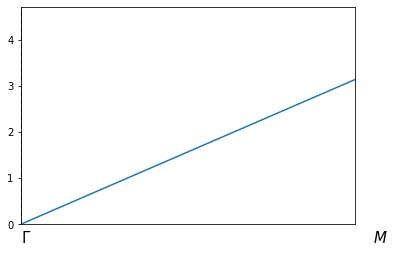

In [3]:
a = 1 # Normalized lattice spacing
stepsize = 20

G_k = [np.pi/a*np.array([0, 0]), '$\\Gamma$']
X_k = [np.pi/a*np.array([1, 0]), '$X$']
M_k = [np.pi/a*np.array([1, 1]), '$M$']
G_k2= [np.pi/a*np.array([2, 0]), '$\\Gamma$']

def HSP(hsp, stepsize):
    
    kx_array = []
    ky_array = []
    
    norm = 0
    hsp_k = 0
    hsp_list = [0]
    
    for i in range(len(hsp) - 1):
        norm = np.linalg.norm(hsp[1][0] - hsp[0][0])
        norm_new = np.linalg.norm(hsp[i + 1][0] - hsp[i][0])
        if i == len(hsp) - 2:
            endpoint = True # Take into account k on last high symmetry point
        else:
            endpoint = False
        kx_new = np.linspace(hsp[i][0][0], hsp[i + 1][0][0], int(stepsize*norm_new/norm), endpoint = endpoint)
        ky_new = np.linspace(hsp[i][0][1], hsp[i + 1][0][1], int(stepsize*norm_new/norm), endpoint = endpoint)
        kx_array = np.hstack([kx_array, kx_new])
        ky_array = np.hstack([ky_array, ky_new])

        hsp_k_new = len(kx_new)
        hsp_k += hsp_k_new
        hsp_list.append(hsp_k)
        
        k_array = np.linspace(0, len(kx_array) - 1, len(kx_array))
    return kx_array, ky_array, k_array, hsp_list

hsp = G_k, M_k # Sequence of high symmetry points

kx_array, ky_array, k_array, hsp_list = HSP(hsp, stepsize)
#print(kx_array)

_list = [0, 2*np.pi]
plt.plot(k_array, kx_array)
plt.ylim(0, 3*np.pi/2)
plt.xticks([])
plt.xlim(0, max(k_array))
for i in range(len(hsp)):
    hsp_point = np.ones(2)*hsp_list[i]
    plt.plot(hsp_point, _list, linestyle = 'dashed', color = 'black')
    plt.text(hsp_list[i], -0.4, hsp[i][1], fontsize = 15)

plt.show()

## Slab confined in the [111] direction
For a simulation of 50 nm, we need a 45 or 46 atom thick slab. Or potentially 91 atoms.

In [4]:
def Slab111(H):
    ham_mass = ("kron(Matrix([[m_Sn, 0],[0, m_Te]]), eye(3))")
    ham_nn = ("2*t*kron(sigma_x, Matrix([[cos(k_x), 0, 0],[0, cos(k_y), 0],[0, 0, cos(k_z)]]))")
    ham_nnn = ("2*kron(Matrix([[t_Sn, 0],[0, t_Te]]), Matrix([[cos(k_x)*(cos(k_y)+cos(k_z)), -sin(k_x)*sin(k_y), -sin(k_x)*sin(k_z)],[-sin(k_y)*sin(k_x), cos(k_y)*(cos(k_x)+cos(k_z)), -sin(k_y)*sin(k_z)],[-sin(k_z)*sin(k_x), -sin(k_z)*sin(k_y), cos(k_z)*(cos(k_x) + cos(k_y))]]))")
    ham_nnpi = ("-2*tpi * kron(sigma_x, Matrix([[cos(k_y) + cos(k_z), 0, 0],[0, cos(k_x) + cos(k_z), 0],[0, 0, cos(k_x) + cos(k_y)]]))")
    ham_nnnpi = ("-2*kron(Matrix([[tpi_Sn, 0],[0, tpi_Te]]), Matrix([[cos(k_y)*cos(k_z), 0, 0],[0, cos(k_x)*cos(k_z), 0],[0, 0, cos(k_x)*cos(k_y)]]))")
    ham = "("+ ham_mass +" + " + ham_nn +" + " + ham_nnn +" + " + ham_nnpi +" + " + ham_nnnpi +")"
    ham_ = "kron(" + ham + ", eye(2))"
    soc = ("Matrix([[0, 0, 1, 0, 0, 1j],[0, 0, 0, -1, -1j, 0],[-1, 0, 0, 0, 0, 1],[0, 1, 0, 0, 1, 0],[0, -1j, 0, -1, 0, 0],[1j, 0, -1, 0, 0, 0]])")
    soi = ("-1j*kron(Matrix([[lambda_Sn, 0],[0, lambda_Te]]), " + soc + ")")
    Ham = "(" + ham_ +" + " + soi +")"
    hamiltonian = qsymm.Model(Ham)

    template = kwant.qsymm.model_to_builder(hamiltonian,
                                            (('Sn', 6), ('Te', 6)),
                                           np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
                                           (([0, 0, 0], [0, 0, 1]))) # For different termination, exchange the 0 and 1
    
    def shape(site):
        (x, y, z) = site.pos
        return  0 <= x + y + z < H  
    
    syst = kwant.Builder(symmetry = kwant.lattice.TranslationalSymmetry([-1, 0, 1], [0, 1, -1]))
    syst.fill(template, shape, (0,0,0))
    
    syst = kwant.wraparound.wraparound(syst)
    syst = syst.finalized()
    
    k0 = 20
    def manual_bands(kx):
        new_params_ = dict(
            m_Sn = -1.65, # This one should be negative
            m_Te =  1.65, # This one should be positive
            t = 0.9, 
            t_Sn = -0.5, # This one should be negative
            t_Te =  0.5, # This one should be positive
            tpi = 0,
            tpi_Sn = 0,
            tpi_Te = 0,
            lambda_Sn = 0.3, 
            lambda_Te = 0.3,
            k_y = 0,
            **dict(k_x = kx))
        H = syst.hamiltonian_submatrix(params = new_params_, sparse = False)
        #ev, es = sla.eigsh(H, k = k0 ,sigma = 0, return_eigenvectors = True)
        ev, es = np.linalg.eigh(H)
        return ev, es
    
    momenta = np.linspace(0, np.pi, 101)
    ev_es = [manual_bands(kx) for kx in momenta]
    
    ## obtain the IPR of each eigenstate
    
    E_k = [i[0] for i in ev_es] # just the eigenvalues
    IIPR = [] #the inverse inverse participation ratio (high for edge states, low for bulk states)
    for k_point in range(len(momenta)):
        sub_iipr = []
        es = ev_es[k_point][1] #eigenvectors at a given k
        for es_point in range(len(es)):
            eigenvector = es[:, es_point]
            treated_entries = []
            for entry in eigenvector:
                treated_entries.append(np.abs(np.conj(entry) * entry) ** 4) #the (inverse) inverse participation ratio
            sub_iipr.append(np.sum(np.array(treated_entries)))
        IIPR.append(sub_iipr)
    m_ = [[momenta[ind] for j in range(len(ev_es[ind][0]))] for ind in range(len(momenta))]
    
    max_iipr = np.max(np.array(IIPR).flatten()) #find the maximum value of the IIPR, so we can normalize all values to a value between 0 and 1

    fig = plt.figure(figsize = (8,8))
    for k_point in range(len(momenta)):
        e_k = E_k[k_point] #select an array of energies at a single point in k-space
        iipr = IIPR[k_point] #select the corresponding IIPR
        k_points = [momenta[k_point] for i in range(len(e_k))]

        rgba_colors = np.zeros((len(iipr), 4))
        rgba_colors[:, 3] = (iipr / max_iipr) **0.3 #the third index of the color sets the transparency, and has to be a value between 0 and 1.

        plt.scatter(k_points, e_k, color=rgba_colors, s=0.3, rasterized=True)
        plt.xlabel(r"k", fontsize = 15)
        plt.ylabel(r"Energy (eV)", fontsize = 15)
        plt.xlim(0, momenta[-1])
        plt.ylim(-5, 5, 0.2)
        
    
    return E_k, IIPR

Wall time: 1min 59s


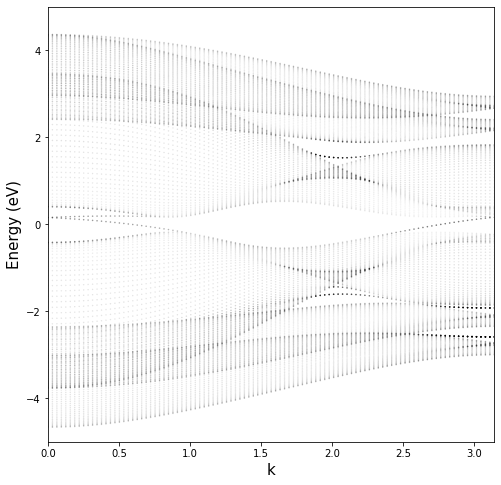

In [5]:
%%time
E_k, IIPR = Slab111(91)

91 90


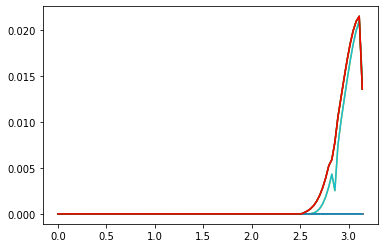

In [6]:
IIPR_ = np.transpose(IIPR)
max_ = np.zeros(len(IIPR_))
k_array = np.linspace(0, np.pi, 101)

largest_1 = np.partition(IIPR_.flatten(), -1)[-1]
index_1 = np.where(IIPR_ == largest_1)[0][0]
#index_2 = index_1 - 1

IIPR_del = np.delete(IIPR_, index_1, 0) # Delete one surface array
largest_2 = np.partition(IIPR_del.flatten(), -1)[-1]
index_2 = np.where(IIPR_del == largest_2)[0][0]

print(index_1, index_2)

for i in range(len(IIPR_[0])):
    plt.plot(k_array, IIPR_[i])
plt.plot(k_array, IIPR_[index_2], color = 'green')
plt.plot(k_array, IIPR_[index_1], color = 'red')

plt.show()

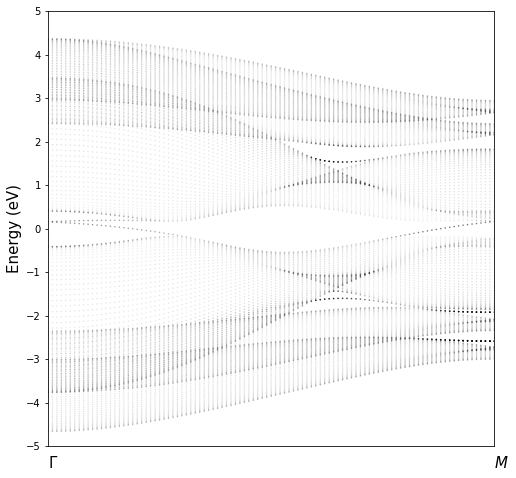

In [7]:
#E_k is your array of eigenvalues (zeroeth index is ordered by k, first index by the total number of energy bands)
#IIPR is your inverse-inverse participation ratio array, that is produced by the previous code snippet I sent
#momenta is your array of k points
minimum = -5
maximum = 5

momenta = np.linspace(0, np.pi, 101)
max_iipr = np.max(np.array(IIPR).flatten()) #find the maximum value of the IIPR, so we can normalize all values to a value between 0 and 1

fig = plt.figure(figsize = (8,8))
for k_point in range(len(momenta)):
    e_k = E_k[k_point] #select an array of energies at a single point in k-space
    iipr = IIPR[k_point] #select the corresponding IIPR
    k_points = [momenta[k_point] for i in range(len(e_k))]


    rgba_colors = np.zeros((len(iipr), 4))

    rgba_colors[:, 3] = (iipr / max_iipr) **0.3 #the third index of the color sets the transparency, and has to be a value between 0 and 1.
    
    plt.scatter(k_points, e_k, color=rgba_colors, s=0.3, rasterized=True)
    
plt.ylabel(r"Energy (eV)", fontsize = 15)
plt.xlim(0, momenta[-1])
plt.ylim(minimum, maximum, 0.2)
plt.yticks(np.arange(minimum, maximum + 0.05, (maximum - minimum)/10))
plt.xticks([])
plt.text(0, minimum - 0.1*maximum, '$\\Gamma$', fontsize = 15)
plt.text(momenta[-1], minimum - 0.1*maximum, '$M$', fontsize = 15)
plt.show()